In [21]:
import logging
import os
import warnings
import ast


import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from datetime import datetime
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers

from utils import *

warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [22]:
print("TF version:", tf.__version__)

TF version: 2.8.0


In [23]:
#!unzip -q train.zip

In [24]:
df_images = pd.read_csv("train_label_converted.csv")
df_images.rename(columns = {'Unnamed: 0':'id', 'label':'labels'}, inplace = True)
df_images.head()

,id,file_name,labels
0,0,72dbecab-8471-454a-8b0d-ae54a8b9501d.jpg,"[808, 673, 45, 289]"
1,1,e13eaae3-c2f3-47a0-aebc-066d5a6737c9.jpg,"[1992, 284, 1423, 228, 3889, 798, 761, 2664]"
2,2,5b8be376-fbdc-41d4-87f4-eda8a1991529.jpg,"[3889, 1315, 2437, 1737, 761, 228, 289, 1923, ..."
3,3,cd624d25-7386-47a8-8b0d-388a877c03c7.jpg,"[2592, 3455, 4249, 284, 1591, 3923, 1549, 1626..."
4,4,89dd6787-420d-4c30-8d69-6031fb69e91a.jpg,"[4161, 2397, 289, 3565, 1186]"


In [25]:
df_labels = pd.read_csv("class_information_english.csv")
df_labels.rename(columns = {'Unnamed: 0':'id', 'english_class':'label'}, inplace = True)
df_labels.head()

,id,label
0,0,Scattered
1,1,One foot
2,2,Bucket
3,3,Right arm
4,4,bookcase


In [26]:
df_images['labels'] = df_images['labels'].apply(lambda x: ast.literal_eval(x))

# Explode the list of strings
df_images = df_images.explode('labels')
df_images.head()

,id,file_name,labels
0,0,72dbecab-8471-454a-8b0d-ae54a8b9501d.jpg,808
0,0,72dbecab-8471-454a-8b0d-ae54a8b9501d.jpg,673
0,0,72dbecab-8471-454a-8b0d-ae54a8b9501d.jpg,45
0,0,72dbecab-8471-454a-8b0d-ae54a8b9501d.jpg,289
1,1,e13eaae3-c2f3-47a0-aebc-066d5a6737c9.jpg,1992


In [27]:
df_images['labels'] = df_images['labels'].astype(str).str.strip()
df_labels['id'] = df_labels['id'].astype(str).str.strip()

In [28]:
merged_df = df_images.merge(df_labels, left_on='labels', right_on='id')

result_df = merged_df.groupby('file_name')['label'].agg(list).reset_index()
result_df.head()

,file_name,label
0,0000afa0-a150-497c-a381-b6611140cd51.jpg,"[woman, Wear, Holding hands, hand in hand, Sky..."
1,0003767f-f783-4c3a-840e-6e557f49b9a3.jpg,"[man, houses, the way, Men, ground, lift, One ..."
2,0003f764-7c70-4111-aa8c-d8b4825f1ccd.jpg,"[man, woman, Stand, hall, Lighter, Room, Ping ..."
3,00042a11-3d05-4867-94ad-b6a120a5ed67.jpg,"[stage, woman, Wear, skirt, walk, light, Hold,..."
4,0012fea3-6abc-4829-b6ae-29a6c7ab69d6.jpg,"[woman, Wear, child, In the house, Room, Chair..."


In [29]:
X_train, X_val, y_train, y_val = train_test_split(result_df['file_name'], result_df['label'], test_size=0.2, random_state=44)
print("Number of posters for training: ", len(X_train))
print("Number of posters for validation: ", len(X_val))

Number of posters for training:  12000
Number of posters for validation:  3000


In [30]:
X_train = [os.path.join('train', str(f)) for f in X_train]
X_val = [os.path.join('train', str(f)) for f in X_val]
X_train[:3]

['train\\cf4cf1df-fcd2-4d47-a564-240c9cff05c7.jpg',
 'train\\775d9069-7e22-424c-9a12-68a45917a686.jpg',
 'train\\5dcc816d-e9fe-4a23-80d5-b89ea35e8c3a.jpg']

In [31]:
y_train = list(y_train)
y_val = list(y_val)
y_train[:3]

[['woman',
  'playground',
  'Wear',
  'red',
  'Sportswear',
  'Hands',
  'Lift',
  'Performance',
  'girl',
  'Arms',
  'girl',
  'stadium',
  'Trojan',
  'Expand',
  'Tights',
  'High -profile'],
 ['stage', 'microphone', 'Glasses', 'billboard', 'Stand', 'Speaking', 'say'],
 ['woman',
  'Wear',
  'Dark color',
  'thing',
  'Side station',
  'Room',
  'sweater',
  'Look at',
  'Head down',
  'washing machine',
  'Light']]

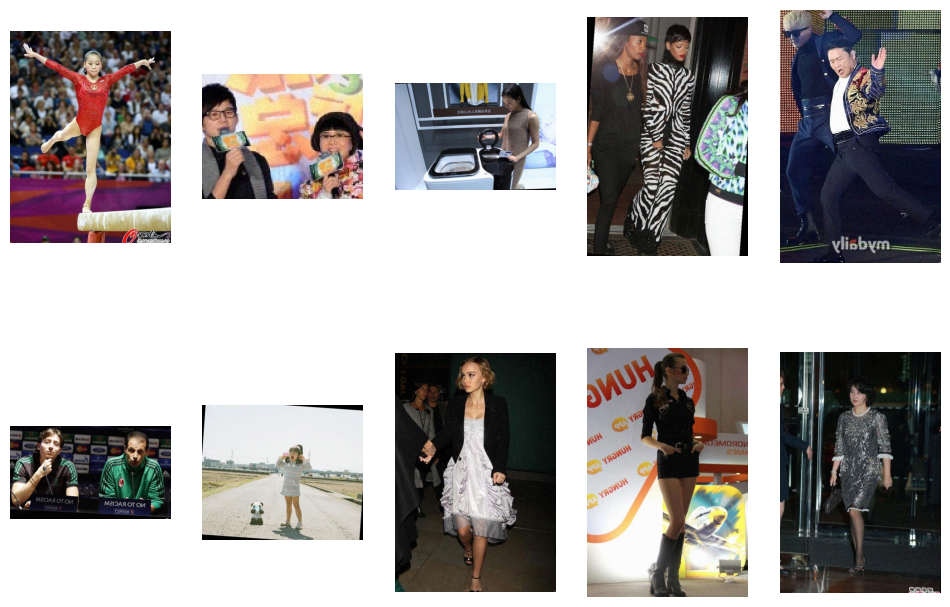

In [32]:
no_img = 10
ncols = 5
nrows = no_img//ncols

style.use("default")
plt.figure(figsize=(12,4*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(X_train[i]))
    #plt.title(y_train[i], size=10)
    plt.axis('off')

In [ ]:
print("Labels:")
mlb = MultiLabelBinarizer()
mlb.fit(y_train)

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))

In [34]:
y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)

In [35]:
for i in range(3):
    print(X_train[i], y_train_bin[i])

train\cf4cf1df-fcd2-4d47-a564-240c9cff05c7.jpg [0 0 0 ... 0 0 0]
train\775d9069-7e22-424c-9a12-68a45917a686.jpg [0 0 0 ... 0 0 0]
train\5dcc816d-e9fe-4a23-80d5-b89ea35e8c3a.jpg [0 0 0 ... 0 0 0]


In [36]:
IMG_SIZE = 224
CHANNELS = 3

def parse_function(filename, label):

    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    image_normalized = image_resized / 255.0

    return image_normalized, label

In [37]:
BATCH_SIZE = 256
AUTOTUNE = tf.data.experimental.AUTOTUNE
SHUFFLE_BUFFER_SIZE = 1024

In [38]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """

    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)

    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)

    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset

train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

In [39]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (256, 224, 224, 3)
Shape of labels array: (256, 3292)


In [44]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

In [45]:
feature_extractor_layer.trainable = False

model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dropout(0.5),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2048)              23564800  
                                                                 
 hidden_layer (Dense)        (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 output (Dense)              (None, 3292)              3374300   
                                                                 
Total params: 29,037,276
Trainable params: 5,472,476
Non-trainable params: 23,564,800
_________________________________________________________________


In [46]:
LR = 1e-5
EPOCHS = 200

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=LR),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=['accuracy'])

history = model.fit(train_ds,
                            epochs=EPOCHS,
                            validation_data=create_dataset(X_val, y_val_bin))

Epoch 1/200
47/47 [==============================] - 1157s 25s/step - loss: 0.7020 - accuracy: 8.3333e-04 - val_loss: 0.6250 - val_accuracy: 0.0013
Epoch 2/200
47/47 [==============================] - 1474s 32s/step - loss: 0.5925 - accuracy: 6.6667e-04 - val_loss: 0.4851 - val_accuracy: 0.0017
Epoch 3/200
47/47 [==============================] - 1455s 31s/step - loss: 0.4333 - accuracy: 0.0010 - val_loss: 0.2886 - val_accuracy: 0.0050
Epoch 4/200
47/47 [==============================] - 1565s 34s/step - loss: 0.2554 - accuracy: 0.0012 - val_loss: 0.1364 - val_accuracy: 0.0063
Epoch 5/200
47/47 [==============================] - 1627s 35s/step - loss: 0.1355 - accuracy: 0.0021 - val_loss: 0.0662 - val_accuracy: 0.0053
Epoch 6/200
47/47 [==============================] - 1610s 34s/step - loss: 0.0775 - accuracy: 0.0025 - val_loss: 0.0392 - val_accuracy: 0.0050
Epoch 7/200
47/47 [==============================] - 1633s 35s/step - loss: 0.0513 - accuracy: 0.0025 - val_loss: 0.0280 - val_a